<a href="https://colab.research.google.com/github/szhaoyu/812lcl.github.com/blob/master/mnist_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

!pip install tqdm
!pip install matploblib

import torch
import torchvision 

from tqdm import tqdm
import matplotlib

ERROR: Could not find a version that satisfies the requirement matploblib (from versions: none)
ERROR: No matching distribution found for matploblib


In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean = [0.5],std = [0.5])])


In [ ]:
print(device)

cpu


In [ ]:
path = './data/'  #数据集下载后保存的目录
trainData = torchvision.datasets.MNIST(path, train = True, transform = transform,download = True)
testData = torchvision.datasets.MNIST(path, train = False, transform = transform,download = True)


In [ ]:
BATCH_SIZE = 256  
trainDataLoader = torch.utils.data.DataLoader(dataset = trainData,batch_size = BATCH_SIZE,shuffle = True)
testDataLoader = torch.utils.data.DataLoader(dataset = testData,batch_size = BATCH_SIZE)

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.model = torch.nn.Sequential(
            #The size of the picture is 28x28
            torch.nn.Conv2d(in_channels = 1,out_channels = 16,kernel_size = 3,stride = 1,padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2,stride = 2),
            
            #The size of the picture is 14x14
            torch.nn.Conv2d(in_channels = 16,out_channels = 32,kernel_size = 3,stride = 1,padding = 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2,stride = 2),
            
            #The size of the picture is 7x7
            torch.nn.Conv2d(in_channels = 32,out_channels = 64,kernel_size = 3,stride = 1,padding = 1),
            torch.nn.ReLU(),
            
            torch.nn.Flatten(),
            torch.nn.Linear(in_features = 7 * 7 * 64,out_features = 128),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features = 128,out_features = 10),
            torch.nn.Softmax(dim=1)
        )
        
    def forward(self,input):
        output = self.model(input)
        return output


In [ ]:
net = Net()
#将模型转换到device中，并将其结构显示出来
print(net.to(device)) 

Net(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=3136, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=10, bias=True)
    (12): Softmax(dim=1)
  )
)


In [ ]:
lossF = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
processBar = tqdm(trainDataLoader,unit = 'step')
net.train(True)

EPOCHS = 10
#存储训练过程
history = {'Test Loss':[],'Test Accuracy':[]}
for epoch in range(1,EPOCHS + 1):
    processBar = tqdm(trainDataLoader,unit = 'step')
    net.train(True)
    for step,(trainImgs,labels) in enumerate(processBar):
        trainImgs = trainImgs.to(device)
        labels = labels.to(device)

        net.zero_grad()
        outputs = net(trainImgs)
        loss = lossF(outputs,labels)
        predictions = torch.argmax(outputs, dim = 1)
        accuracy = torch.sum(predictions == labels)/labels.shape[0]
        loss.backward()

        optimizer.step()
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" % 
                                   (epoch,EPOCHS,loss.item(),accuracy.item()))
        
        if step == len(processBar)-1:
            correct,totalLoss = 0,0
            net.train(False)
            for testImgs,labels in testDataLoader:
                testImgs = testImgs.to(device)
                labels = labels.to(device)
                outputs = net(testImgs)
                loss = lossF(outputs,labels)
                predictions = torch.argmax(outputs,dim = 1)
                
                totalLoss += loss
                correct += torch.sum(predictions == labels)
            testAccuracy = correct/(BATCH_SIZE * len(testDataLoader))
            testLoss = totalLoss/len(testDataLoader)
            history['Test Loss'].append(testLoss.item())
            history['Test Accuracy'].append(testAccuracy.item())
            processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" % 
                                   (epoch,EPOCHS,loss.item(),accuracy.item(),testLoss.item(),testAccuracy.item()))
    processBar.close()


  0%|          | 0/235 [00:00<?, ?step/s]

[1/10] Loss: 1.6333, Acc: 0.8333: 100%|█████████▉| 234/235 [00:58<00:00,  3.72step/s]
[1/10] Loss: 1.5865, Acc: 0.8333, Test Loss: 1.5875, Test Acc: 0.8542: 100%|█████████▉| 234/235 [01:03<00:00,  3.72step/s]
[1/10] Loss: 1.5865, Acc: 0.8333, Test Loss: 1.5875, Test Acc: 0.8542: 100%|██████████| 235/235 [01:03<00:00,  3.71step/s]
[2/10] Loss: 1.4612, Acc: 0.9375, Test Loss: 1.4854, Test Acc: 0.9541: 100%|██████████| 235/235 [00:58<00:00,  4.00step/s]
[3/10] Loss: 1.4613, Acc: 0.9896, Test Loss: 1.4775, Test Acc: 0.9614: 100%|██████████| 235/235 [00:58<00:00,  4.04step/s]
[4/10] Loss: 1.4612, Acc: 1.0000, Test Loss: 1.4793, Test Acc: 0.9591: 100%|██████████| 235/235 [00:58<00:00,  4.04step/s]
[5/10] Loss: 1.4612, Acc: 0.9583, Test Loss: 1.4752, Test Acc: 0.9635: 100%|██████████| 235/235 [00:57<00:00,  4.06step/s]
[6/10] Loss: 1.4612, Acc: 0.9896, Test Loss: 1.4762, Test Acc: 0.9621: 100%|██████████| 235/235 [00:56<00:00,  4.12step/s]
[7/10] Los

In [63]:
from PIL import Image

item = testDataLoader.dataset.data[0]
im = Image.fromarray(item.numpy())
im.save('7.bmp', 'bmp')


torch.Size([1, 28, 28])
torch.Size([1, 1, 28, 28])
tensor([7])


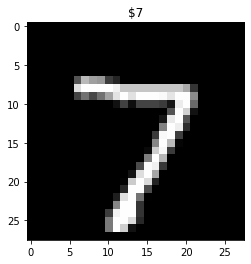

In [73]:
from torchvision import transforms
train_transform = transforms.Compose([
         transforms.Grayscale(),
         transforms.Resize((28, 28)),
         transforms.ToTensor(),
         ])
im = Image.open('7.bmp')
imdata = train_transform(im)
print(imdata.shape)
imdata = torch.unsqueeze(imdata, dim=0)
print(imdata.shape)

outputs = net(imdata)
predictions = torch.argmax(outputs, dim = 1)

print(predictions)

plt.imshow(im, cmap='gray')
predict = predictions[0]
plt.title(f'${predict}')
plt.show()

In [ ]:
# torch.save(net,'./model.pth')
item = testDataLoader.dataset.data[0]
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

for testImgs,labels in testDataLoader:
    testImgs = testImgs.to(device)
    print(testImgs.shape)
    image = torch.unsqueeze(testImgs[0], dim=0)
    print(image.shape)
    labels = labels.to(device)
    outputs = net(image)
    predictions = torch.argmax(outputs, dim = 1)
    print(labels)
    print(predictions)
    item = item.numpy()
    print(item.shape)
    # item = item.reshape(28, 28, 1)
    plt.imshow(testImgs[0][0].numpy(), cmap='gray')
    predit = predictions[0]
    # plt.title(f'${predict}')
    plt.show()

    break



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

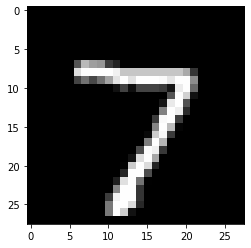

In [ ]:
item = testDataLoader.dataset.data[0]
import matplotlib.pyplot as plt
import numpy as np

# print(item)

image = item.numpy()
# print(image)
# image = image.reshape(28, 28, 1)
plt.imshow(image, cmap='gray')
plt.show()



In [ ]:
print(testDataLoader.dataset.test_labels[0].numpy())
outputs = net(torch.unsqueeze(item, dim=0))
predictions = torch.argmax(outputs,dim = 1)

7


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


RuntimeError: ignored